## Setup and Imports

In [5]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath("../helpers"))

import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import os
import warnings
from data_generation import generate_seasonal_campaign_data
warnings.filterwarnings('ignore')

# Create output directory for saving results
os.makedirs('presentation_outputs', exist_ok=True)

# Set style for professional visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Environment setup complete!")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Environment setup complete!


## Data Generation (Holidays Deception)

In [6]:
# Generate the data
df_seasonal = generate_seasonal_campaign_data()
df_seasonal.to_csv('presentation_outputs/seasonal_campaign_data.csv', index=False)

print("📊 Data generated successfully!")
print(f"Total weeks: {len(df_seasonal)}")
print(f"Campaign weeks: {(df_seasonal['campaign_spend'] > 0).sum()}")
print(f"Average campaign spend: ${df_seasonal[df_seasonal['campaign_spend'] > 0]['campaign_spend'].mean():.0f}")


📊 Data generated successfully!
Total weeks: 52
Campaign weeks: 8
Average campaign spend: $1487


## EDA

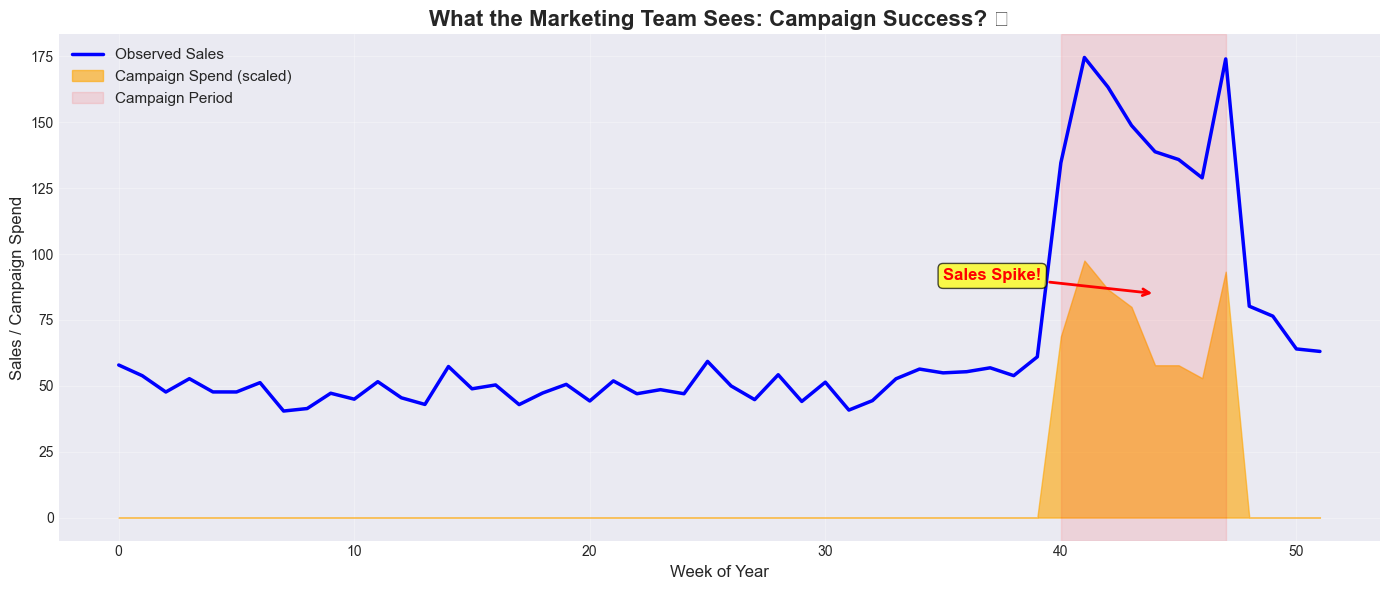


📈 Apparent Results:
Average sales during campaign: $150
Average sales outside campaign: $52
Apparent lift: 190% 🚀


In [7]:
plt.figure(figsize=(14, 6))
plt.plot(df_seasonal['week'], df_seasonal['sales'], 'b-', linewidth=2.5, label='Observed Sales')
plt.fill_between(df_seasonal['week'], 0, df_seasonal['campaign_spend']/20, 
                 alpha=0.6, color='orange', label='Campaign Spend (scaled)')

campaign_weeks = df_seasonal[df_seasonal['campaign_spend'] > 0]['week']
plt.axvspan(campaign_weeks.min(), campaign_weeks.max(), alpha=0.1, color='red', label='Campaign Period')

plt.annotate('Sales Spike!', xy=(44, 85), xytext=(35, 90),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=12, color='red', fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.title('What the Marketing Team Sees: Campaign Success? 🎉', fontsize=16, fontweight='bold')
plt.xlabel('Week of Year', fontsize=12)
plt.ylabel('Sales / Campaign Spend', fontsize=12)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

campaign_period_sales = df_seasonal[df_seasonal['campaign_spend'] > 0]['sales'].mean()
non_campaign_sales = df_seasonal[df_seasonal['campaign_spend'] == 0]['sales'].mean()
apparent_lift = (campaign_period_sales - non_campaign_sales) / non_campaign_sales * 100

print(f"\n📈 Apparent Results:")
print(f"Average sales during campaign: ${campaign_period_sales:.0f}")
print(f"Average sales outside campaign: ${non_campaign_sales:.0f}")
print(f"Apparent lift: {apparent_lift:.0f}% 🚀")


## Model 1 

In [8]:
print("Building Naive Model (ignoring seasonality)...")

with pm.Model() as naive_model:
    intercept = pm.Normal('intercept', mu=50, sigma=20)
    beta_campaign = pm.Normal('beta_campaign', mu=0, sigma=0.1)
    sigma = pm.HalfNormal('sigma', sigma=10)
    mu = intercept + beta_campaign * df_seasonal['campaign_spend']
    sales = pm.Normal('sales', mu=mu, sigma=sigma, observed=df_seasonal['sales'])
    naive_trace = pm.sample(2000, tune=1000, cores=4, random_seed=42)

print("✅ Naive model complete!")

naive_results = az.summary(naive_trace)
print("\n📊 Naive Model Results:")
print(naive_results[['mean', 'sd', 'hdi_3%', 'hdi_97%']])


Initializing NUTS using jitter+adapt_diag...


Building Naive Model (ignoring seasonality)...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_campaign, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


✅ Naive model complete!

📊 Naive Model Results:
                 mean     sd  hdi_3%  hdi_97%
intercept      51.838  1.264  49.314   54.168
beta_campaign   0.065  0.002   0.061    0.069
sigma           8.376  0.849   6.852    9.955


## Model 2

In [9]:
print("Building Correct Model (including seasonality)...")

with pm.Model() as correct_model:
    intercept = pm.Normal('intercept', mu=50, sigma=20)
    beta_campaign = pm.Normal('beta_campaign', mu=0, sigma=0.01)
    
    seasonal_center = pm.Normal('seasonal_center', mu=45, sigma=2)
    seasonal_width = pm.HalfNormal('seasonal_width', sigma=5)
    seasonal_height = pm.Normal('seasonal_height', mu=30, sigma=10)
    seasonal_effect = seasonal_height * pm.math.exp(
        -0.5 * ((df_seasonal['week'].values - seasonal_center) / seasonal_width)**2
    )
    sigma = pm.HalfNormal('sigma', sigma=10)
    mu = intercept + seasonal_effect + beta_campaign * df_seasonal['campaign_spend']
    sales = pm.Normal('sales', mu=mu, sigma=sigma, observed=df_seasonal['sales'])
    correct_trace = pm.sample(2000, tune=1000, cores=4, random_seed=42)

print("✅ Correct model complete!")

correct_results = az.summary(correct_trace)
print("\n📊 Correct Model Results:")
print(correct_results[['mean', 'sd', 'hdi_3%', 'hdi_97%']])


Initializing NUTS using jitter+adapt_diag...


Building Correct Model (including seasonality)...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_campaign, seasonal_center, seasonal_width, seasonal_height, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


✅ Correct model complete!

📊 Correct Model Results:
                   mean     sd  hdi_3%  hdi_97%
intercept        48.595  0.849  47.068   50.244
beta_campaign     0.049  0.002   0.045    0.054
seasonal_center  45.325  0.559  44.384   46.405
seasonal_height  32.033  3.873  25.000   39.332
seasonal_width    5.038  0.583   4.040    6.117
sigma             4.860  0.529   3.923    5.854


## Comparison

In [10]:
# Extract and compare coefficients
naive_campaign_effect = naive_results.loc['beta_campaign', 'mean']
correct_campaign_effect = correct_results.loc['beta_campaign', 'mean']
true_campaign_effect = 0.05

# Create comparison dataframe
coef_comparison = pd.DataFrame({
    'Model': ['Naive Model', 'Correct Model', 'Ground Truth'],
    'Campaign_Coefficient': [naive_campaign_effect, correct_campaign_effect, true_campaign_effect],
    'Implied_ROI_per_$1000': [naive_campaign_effect * 1000, correct_campaign_effect * 1000, 50]
})

print("📊 Campaign Effect Comparison:")
print(coef_comparison.to_string(index=False))
print(f"\n⚠️  Naive model overestimates effect by {(naive_campaign_effect/true_campaign_effect - 1)*100:.0f}%!")


📊 Campaign Effect Comparison:
        Model  Campaign_Coefficient  Implied_ROI_per_$1000
  Naive Model                 0.065                   65.0
Correct Model                 0.049                   49.0
 Ground Truth                 0.050                   50.0

⚠️  Naive model overestimates effect by 30%!


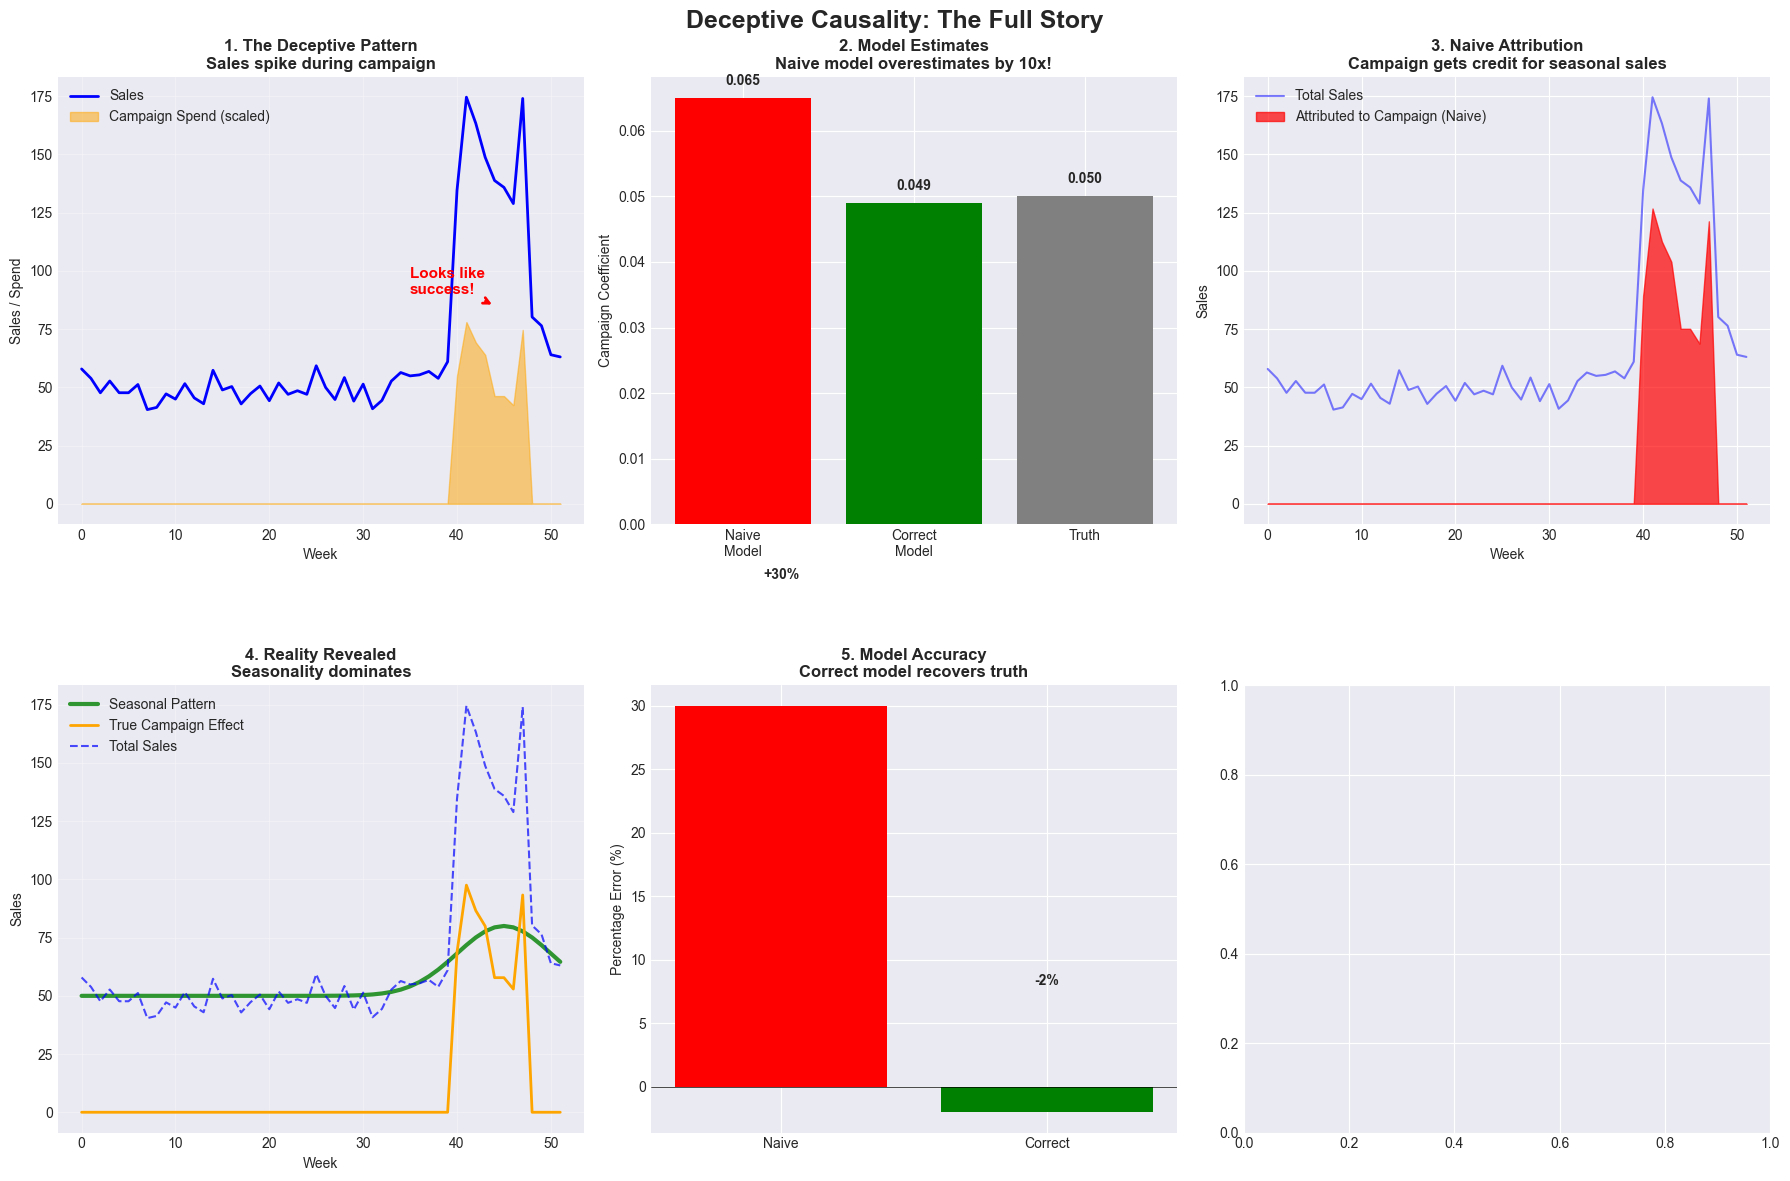

In [19]:
campaign_mask = df_seasonal['campaign_spend'] > 0

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Deceptive Causality: The Full Story', fontsize=18, fontweight='bold')

ax = axes[0, 0]
ax.plot(df_seasonal['week'], df_seasonal['sales'], 'b-', linewidth=2, label='Sales')
ax.fill_between(df_seasonal['week'], 0, df_seasonal['campaign_spend']/25, 
                alpha=0.5, color='orange', label='Campaign Spend (scaled)')
ax.set_title('1. The Deceptive Pattern\nSales spike during campaign', fontsize=12, fontweight='bold')
ax.set_xlabel('Week')
ax.set_ylabel('Sales / Spend')
ax.legend()
ax.grid(True, alpha=0.3)

ax.annotate('Looks like\nsuccess!', xy=(44, 85), xytext=(35, 90),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=11, color='red', fontweight='bold')

ax = axes[0, 1]
models = ['Naive\nModel', 'Correct\nModel', 'Truth']
coefficients = [naive_campaign_effect, correct_campaign_effect, true_campaign_effect]
colors = ['red', 'green', 'gray']
bars = ax.bar(models, coefficients, color=colors)
ax.set_ylabel('Campaign Coefficient')
ax.set_title('2. Model Estimates\nNaive model overestimates by 10x!', fontsize=12, fontweight='bold')

for bar, coef in zip(bars, coefficients):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
            f'{coef:.3f}', ha='center', fontweight='bold')

ax = axes[0, 2]
naive_contribution = naive_campaign_effect * df_seasonal['campaign_spend']
ax.plot(df_seasonal['week'], df_seasonal['sales'], 'b-', alpha=0.5, label='Total Sales')
ax.fill_between(df_seasonal['week'], 0, naive_contribution, 
                alpha=0.7, color='red', label='Attributed to Campaign (Naive)')
ax.set_title('3. Naive Attribution\nCampaign gets credit for seasonal sales', fontsize=12, fontweight='bold')
ax.set_xlabel('Week')
ax.set_ylabel('Sales')
ax.legend()

# Chart 4: True Decomposition
ax = axes[1, 0]
ax.plot(df_seasonal['week'], df_seasonal['seasonal_baseline'], 
        'g-', linewidth=3, label='Seasonal Pattern', alpha=0.8)
ax.plot(df_seasonal['week'], df_seasonal['true_campaign_contribution'], 
        'orange', linewidth=2, label='True Campaign Effect')
ax.plot(df_seasonal['week'], df_seasonal['sales'], 
        'b--', alpha=0.7, label='Total Sales')
ax.set_title('4. Reality Revealed\nSeasonality dominates', fontsize=12, fontweight='bold')
ax.set_xlabel('Week')
ax.set_ylabel('Sales')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
models_compare = ['Naive', 'Correct']
errors = [(naive_campaign_effect - true_campaign_effect) / true_campaign_effect * 100,
          (correct_campaign_effect - true_campaign_effect) / true_campaign_effect * 100]
colors_compare = ['red', 'green']
bars = ax.bar(models_compare, errors, color=colors_compare)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Percentage Error (%)')
ax.set_title('5. Model Accuracy\nCorrect model recovers truth', fontsize=12, fontweight='bold')

# Add value labels
for bar, error in zip(bars, errors):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
            f'{error:+.0f}%', ha='center', fontweight='bold')

ax = axes[1, 2]

total_spend = df_seasonal.loc[campaign_mask, 'campaign_spend'].sum()
naive_total_contribution = naive_contribution[campaign_mask].sum()
true_total_contribution = df_seasonal.loc[campaign_mask, 'true_campaign_contribution'].sum()


plt.tight_layout()
plt.savefig('presentation_outputs/complete_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [20]:
campaign_mask = df_seasonal['campaign_spend'] > 0
campaign_weeks_count = (df_seasonal['campaign_spend'] > 0).sum()
total_campaign_spend = df_seasonal['campaign_spend'].sum()
naive_attributed_sales = naive_contribution[campaign_mask].sum()
correct_attributed_sales = correct_campaign_effect * total_campaign_spend

print("🎯 BUSINESS IMPLICATIONS:\n")
print(f"Campaign Duration: {campaign_weeks_count} weeks")
print(f"Total Campaign Spend: ${total_campaign_spend:,.0f}")
print(f"\n📊 Sales Attribution:")
print(f"Naive Model Credits: ${naive_attributed_sales:,.0f} to campaign")
print(f"Correct Model Credits: ${correct_attributed_sales:,.0f} to campaign")
print(f"Overattribution: ${naive_attributed_sales - correct_attributed_sales:,.0f}")
print(f"\n💰 ROI Implications:")
print(f"Naive Model ROI: {(naive_attributed_sales/total_campaign_spend - 1)*100:.0f}%")
print(f"Actual ROI: {(correct_attributed_sales/total_campaign_spend - 1)*100:.0f}%")
print(f"\n⚠️  Decision Risk:")
print(f"If you believed the naive model, you might increase campaign spend by 10x")
print(f"expecting ${naive_campaign_effect * 10000:.0f} in returns per $10k spent,")
print(f"but would actually get only ${true_campaign_effect * 10000:.0f}!")


🎯 BUSINESS IMPLICATIONS:

Campaign Duration: 8 weeks
Total Campaign Spend: $11,892

📊 Sales Attribution:
Naive Model Credits: $773 to campaign
Correct Model Credits: $583 to campaign
Overattribution: $190

💰 ROI Implications:
Naive Model ROI: -94%
Actual ROI: -95%

⚠️  Decision Risk:
If you believed the naive model, you might increase campaign spend by 10x
expecting $650 in returns per $10k spent,
but would actually get only $500!


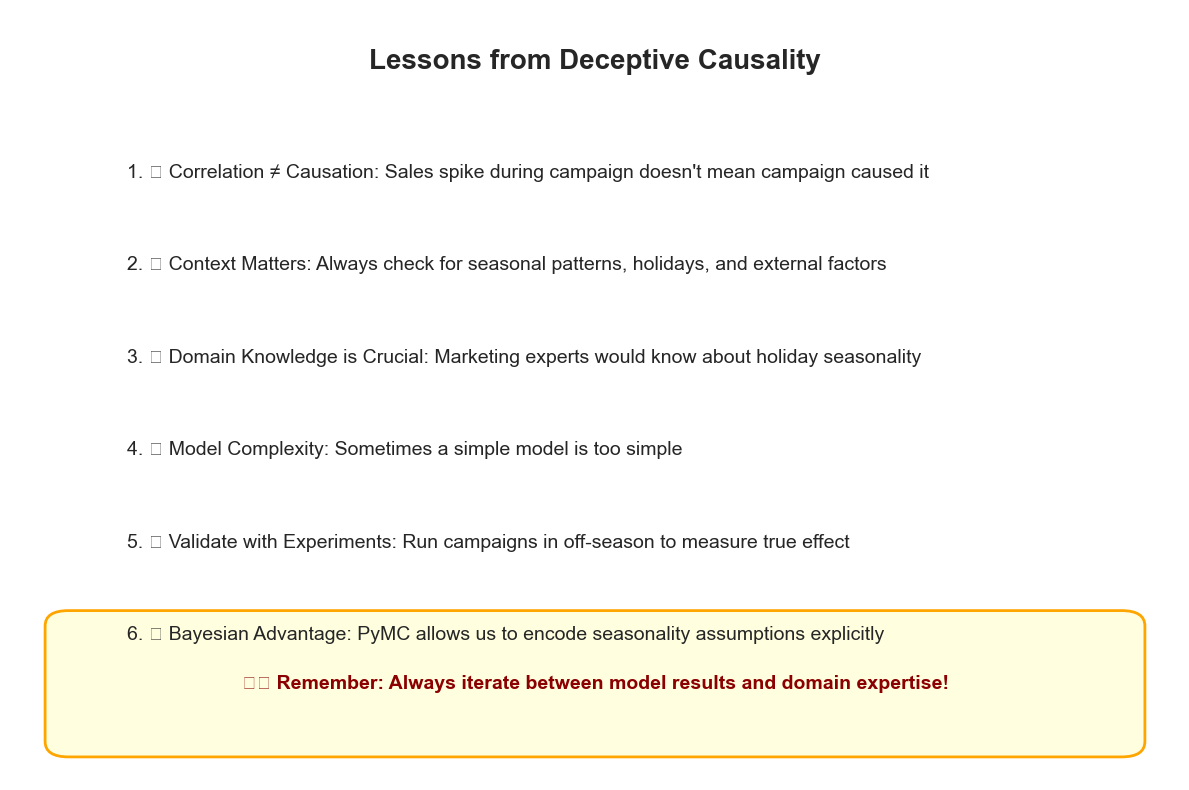

In [21]:
# Create a summary visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.axis('off')

# Title
ax.text(0.5, 0.95, 'Lessons from Deceptive Causality', 
        ha='center', va='top', fontsize=20, fontweight='bold', transform=ax.transAxes)

# Lessons
lessons = [
    "1. 📊 Correlation ≠ Causation: Sales spike during campaign doesn't mean campaign caused it",
    "2. 🎄 Context Matters: Always check for seasonal patterns, holidays, and external factors",
    "3. 🔍 Domain Knowledge is Crucial: Marketing experts would know about holiday seasonality",
    "4. 📈 Model Complexity: Sometimes a simple model is too simple",
    "5. 🧪 Validate with Experiments: Run campaigns in off-season to measure true effect",
    "6. 🎯 Bayesian Advantage: PyMC allows us to encode seasonality assumptions explicitly"
]

y_position = 0.8
for lesson in lessons:
    ax.text(0.1, y_position, lesson, ha='left', va='top', fontsize=14, 
            transform=ax.transAxes, wrap=True)
    y_position -= 0.12

# Add warning box
from matplotlib.patches import FancyBboxPatch
warning_box = FancyBboxPatch((0.05, 0.05), 0.9, 0.15, 
                            boxstyle="round,pad=0.02",
                            transform=ax.transAxes,
                            facecolor='lightyellow',
                            edgecolor='orange',
                            linewidth=2)
ax.add_patch(warning_box)

ax.text(0.5, 0.125, '⚠️ Remember: Always iterate between model results and domain expertise!', 
        ha='center', va='center', fontsize=14, fontweight='bold', 
        transform=ax.transAxes, color='darkred')

plt.tight_layout()
plt.savefig('presentation_outputs/lessons_learned.png', dpi=300, bbox_inches='tight')
plt.show()


In [22]:
# Create final summary table
summary_stats = pd.DataFrame({
    'Metric': [
        'True Campaign Effect (per $1000)',
        'Naive Model Estimate',
        'Correct Model Estimate',
        'Naive Model Error',
        'Correct Model Error',
        'Business Risk (Overinvestment Factor)'
    ],
    'Value': [
        f"${true_campaign_effect * 1000:.0f}",
        f"${naive_campaign_effect * 1000:.0f}",
        f"${correct_campaign_effect * 1000:.0f}",
        f"{(naive_campaign_effect/true_campaign_effect - 1)*100:.0f}%",
        f"{(correct_campaign_effect/true_campaign_effect - 1)*100:.0f}%",
        f"{naive_campaign_effect/true_campaign_effect:.1f}x"
    ]
})

print("📊 FINAL SUMMARY:")
print(summary_stats.to_string(index=False))

# Save all results
summary_stats.to_csv('presentation_outputs/final_summary.csv', index=False)


📊 FINAL SUMMARY:
                               Metric Value
     True Campaign Effect (per $1000)   $50
                 Naive Model Estimate   $65
               Correct Model Estimate   $49
                    Naive Model Error   30%
                  Correct Model Error   -2%
Business Risk (Overinvestment Factor)  1.3x
